## Assignment 4
In This assignement I have taken CIFAR 10 dataset from torchvision library . In general image recongintion deep neural network have following strcuture. <br>
1) Convolution layers <br>
2) Relu <br>
3) Pooling Layer <br>
4) Fully Connected linear <br>
Based on these structure I have referenced code from (https://github.com/python-engineer/pytorchTutorial/blob/master/14_cnn.py) inorder to implement baseline model in pytorch . Belowe are the changes I have done and compared the performance of those changes with baseline model.<br>
1) Implement Dropout regularization<br>
2) Instead of using max pooling use average pooling <br>
3) Use batch normalization <br>

### Step 1 : import necessary library

In [58]:
import torch 
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import time

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cpu')

### step 2 : Download CIFAR 10 dataset and convert it into tensor

In [5]:
data_root =  '../data-unversioned/p1ch7/'
transform = transforms.Compose([transforms.ToTensor()])
train_dataset =  torchvision.datasets.CIFAR10(root=data_root,train=True,download=True,transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root=data_root,train=False,download=True,transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
img_t, _ = train_dataset[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

### step 3 :  Normalization of data 
In this step we have created mean and standarad deviation and normalized the image in order to reduce training time.

In [6]:
train_img = [img_t for img_t, _ in train_dataset]
test_img= ([img_t for img_t, _ in test_dataset])
my_img = train_img + test_img
imgs = torch.stack(my_img, dim=3)

In [7]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4919, 0.4828, 0.4474])

In [8]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2434, 0.2616])

In [9]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.4919, 0.4828, 0.4474), (0.2470, 0.2434, 0.2616))])

In [10]:
train_dataset =  torchvision.datasets.CIFAR10(root=data_root,train=True,download=False,transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root=data_root,train=False,download=False,transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


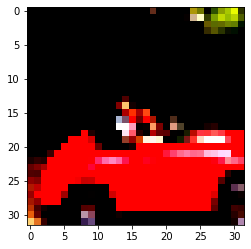

In [11]:
img_t, _ = train_dataset[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

### step 4 : Convert dataset into Dataloader 
During training process we iterate through data in batch and if we are using stochastic gardient descent then we want 
to iterate those batches in random order.Using Dataloader makes it easier to dot that.

In [13]:
num_epochs = 100
batch_size = 10
learning_rate = 0.001

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

In [15]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [16]:
train_dataset[0][0].view(-1).shape

torch.Size([3072])

### step 5  Implement Model 
As we have suggested base line model contains 2 convolution with pooling layers and 3 fully connected linear layer after that . Along with baseline model we have created 3 new model and we will compare the performance of all the models.
1) Baseline model
2) Baseline model with dropout regularization
3) Baseline model with average pooling
4) Baseline model with batch normalization

In [17]:
class ImageClassification(nn.Module):
    def __init__(self):
        super(ImageClassification,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.fc1(x.view(-1,16 * 5 * 5)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
class ImageClassificationWithDropOut(nn.Module):
    def __init__(self):
        super(ImageClassificationWithDropOut,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.dropout = nn.Dropout(0.3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.fc1(x.view(-1,16 * 5 * 5)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
class ImageClassificationWithAvgPooling(nn.Module):
     def __init__(self):
        super(ImageClassificationWithAvgPooling,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.AvgPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    
     def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.fc1(x.view(-1,16 * 5 * 5)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [42]:
class ImageClassificationWithBatchNorm(nn.Module):
    def __init__(self):
        super(ImageClassificationWithBatchNorm,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.batchnorm = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv2(x)
        x = self.batchnorm(x)
        x = self.pool(F.relu(x))
        x = F.relu(self.fc1(x.view(-1,16 * 5 * 5)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
     
    

### step 6 :Train a model 
In this method we will train the model which will return the train accuracy with epoch,test accuracy with epoch and class_wise_accuracy . 

In [71]:
def train_model(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    total_steps = len(train_dataset)
    train_accuracy = []
    test_accuracy = []
    class_wise_accuracy = []
    for epochs in range(20):
        for i,(images,labels) in enumerate(train_loader):
            outputs = model(images)
            loss = criterion(outputs,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():        
            n_correct = 0
            n_samples = 0
            for images,labels in test_loader:
                outputs = model(images)
                _,predicted = torch.max(outputs,1)
                n_samples += labels.size(0)
                n_correct += (predicted==labels).sum().item() 
            train_accuracy.append(100.0 * n_correct/ n_samples)    
            n_correct = 0
            n_samples = 0
            for images,labels in train_loader:
                outputs = model(images)
                _,predicted = torch.max(outputs,1)
                n_samples += labels.size(0)
                n_correct += (predicted==labels).sum().item()
            test_accuracy.append(100.0 * n_correct/ n_samples)    
                


    print('Training Finished')
    
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(10)]
        n_class_samples = [0 for i in range(10)]

        for images,labels in test_loader:
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            n_samples += labels.size(0)
            n_correct += (predicted==labels).sum().item()

            for i in range(batch_size):
                label = labels[i]
                pred = predicted[i]
                if(label==pred):
                    n_class_correct[label]+=1
                n_class_samples[label]+=1
        acc = 100.0 * n_correct/ n_samples 
        print(f'Accuracy of the network : {acc}%')
        
        for i in range(10):
            acc = 100.0 * n_class_correct[i]/n_class_samples[i]
            class_wise_accuracy.append(acc)
            
    return  train_accuracy,test_accuracy,class_wise_accuracy        
            

In [72]:
execution_time = []
model = ImageClassification()
start_time = time.time()
train_accuracy_1,test_accuracy_1,class_wise_accuracy_1= train_model(model)
execution_time.append(time.time()-start_time)

Training Finished
Accuracy of the network : 59.23%


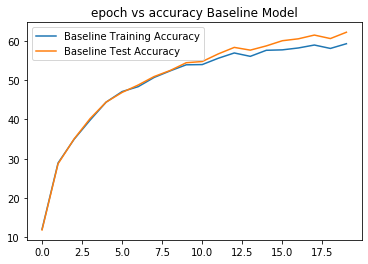

In [81]:
plt.plot(train_accuracy_1, label="Baseline Training Accuracy")
plt.plot(test_accuracy_1, label="Baseline Test Accuracy")
plt.title("epoch vs accuracy Baseline Model")
plt.legend();

In [74]:
model = ImageClassificationWithDropOut()
start_time = time.time()
train_accuracy_2,test_accuracy_2,class_wise_accuracy_2= train_model(model)
execution_time.append(time.time()-start_time)

Training Finished
Accuracy of the network : 57.67%


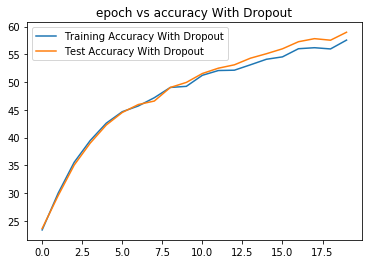

In [82]:
plt.plot(train_accuracy_2, label="Training Accuracy With Dropout")
plt.plot(test_accuracy_2, label="Test Accuracy With Dropout")
plt.title("epoch vs accuracy With Dropout")
plt.legend();

In [76]:
model = ImageClassificationWithAvgPooling()
start_time = time.time()
train_accuracy_3,test_accuracy_3,class_wise_accuracy_3= train_model(model)
execution_time.append(time.time()-start_time)

Training Finished
Accuracy of the network : 52.59%


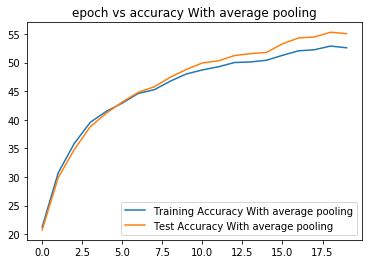

In [83]:
plt.plot(train_accuracy_3, label="Training Accuracy With average pooling")
plt.plot(test_accuracy_3, label="Test Accuracy With average pooling")
plt.title("epoch vs accuracy With average pooling")
plt.legend();

In [78]:
model = ImageClassificationWithBatchNorm()
start_time = time.time()
train_accuracy_4,test_accuracy_4,class_wise_accuracy_4= train_model(model)
execution_time.append(time.time()-start_time)

Training Finished
Accuracy of the network : 61.62%


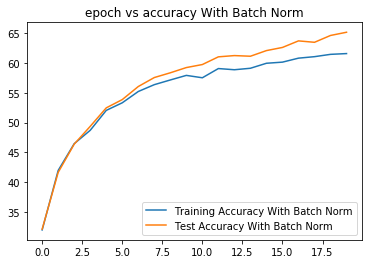

In [84]:
plt.plot(train_accuracy_4, label="Training Accuracy With Batch Norm")
plt.plot(test_accuracy_4, label="Test Accuracy With Batch Norm")
plt.title("epoch vs accuracy With Batch Norm")
plt.legend();

### step 7 Conclusion 
As we can see batch normalization improves the accuracy of the model , while drop out and average pooling doesn't 
have much impact on the accuracy. One reason for no improvement with dropout regularization might be that we have used dropout probability 0.3 which might be high for small network . Also since My computer don't have gpu I have used 20 iteration , So it might be the case that with increased iteration dropout might give higher accuracy.

In [85]:
class_wise_accuracy_1

[71.4, 62.0, 50.1, 38.6, 49.7, 45.7, 74.6, 63.5, 75.0, 61.7]

In [86]:
class_wise_accuracy_2

[63.5, 62.5, 49.2, 44.1, 46.8, 44.2, 62.2, 65.7, 69.3, 69.2]

In [87]:
class_wise_accuracy_3

[53.4, 57.3, 40.2, 34.6, 53.0, 37.1, 63.8, 62.5, 68.3, 55.7]

In [88]:
class_wise_accuracy_4

[63.5, 73.9, 44.8, 41.9, 62.6, 42.5, 69.9, 70.0, 73.2, 73.9]